In [11]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [12]:
# Normalisation of angle
def normalize_angle(angle):
    if angle < 0:
        angle = angle % (-2 * np.pi)
    else:
        angle = angle % (2 * np.pi)

    if angle > np.pi:
        angle = -(2 * np.pi - angle)
    if angle < -np.pi:
        angle = (2 * np.pi + angle)

    return angle

# normalize_angle(8.4)

In [13]:
# LOS Algorithm
def LOS(x, y, xk, yk, delta_h):
    gamma_p = np.arctan2(yk[1] - yk[0], xk[1] - xk[0])

    xe = (x - xk[0]) * np.cos(gamma_p) + (y - yk[0]) * np.sin(gamma_p)
    ye = -(x - xk[0]) * np.sin(gamma_p) + (y - yk[0]) * np.cos(gamma_p)

    los_error = np.array([xe, ye])
    psi_d = gamma_p + np.arctan2(-los_error[1], delta_h)

    psi_d = normalize_angle(psi_d)

    return psi_d, los_error

In [14]:
# PID Controller
class PIDController:
    def __init__(self, Kp, Ki, Kd, prev_error, integral):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = prev_error
        self.integral = integral

    def update(self, error, dt):
        self.integral += error * dt
        derivative = (error - self.prev_error) / dt
        delta = self.Kp * error + self.Ki * self.integral + self.Kd * derivative
        self.prev_error = error
        return delta

In [15]:
# Constants for Nomoto 1st Order Dynamics
k = 0.145
T = 1.0
initial_condition=[0.0,0.0,0.0,0.0]
delta=0.1

# Runge-Kutta 4th order method for Nomoto 1st Order Dynamics
def runge_kutta_nomoto(x_array, y_array, psi_array, r_array, delta, del_t):

    def by_ivp(t, r, delta):
        return (k * delta - r) / T

    t_span=(0, 10)
    sol = solve_ivp(
        fun=lambda t, y: by_ivp(t, y, delta),
        t_span=t_span,
        y0=initial_condition,
        method='RK45',
        dense_output=True)
    t=np.linspace(t_span[0], t_span[1], 1000)
    new_r = sol.sol(t)

    r = np.append(r_array, new_r)

    # Update psi, normalize it
    new_psi = psi_array[-1] + r[-1] * del_t
    new_psi = normalize_angle(new_psi)

    psi = np.append(psi_array, new_psi)
    new_x = x_array[-1] + u*np.cos(psi[-1]) * del_t
    x = np.append(x_array, new_x)

    new_y = y_array[-1] + u*np.sin(psi[-1]) * del_t
    y = np.append(y_array, new_y)

    return x, y, psi, r

In [16]:
#Path length
def dist(xa,ya,xb,yb):
    return np.sqrt((xa-xb)**2 + (ya-yb)**2)

In [17]:
def draw_circle(center, radius):
    theta = np.linspace(0, 2*np.pi, 100)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)

    plt.plot(x, y, label='Circle')
    plt.scatter(center[0], center[1], color='red', marker='o', label='Center')

def divide_circle(center, radius, num_waypoints):
    theta = np.linspace(0, 2*np.pi, num_waypoints)
    waypoints_x = center[0] + radius * np.cos(theta)
    waypoints_y = center[1] + radius * np.sin(theta)

    return waypoints_x, waypoints_y

def generate_straight_line_path(start, end, num_points):

    x_values = np.linspace(start, end, num_points)
    y_values = np.zeros_like(x_values)
    return x_values, y_values

xk=[7.         6.62072069] and yk = [0.         2.27289628]
Termination_1 at steps =12 at waypoint 1
xk=[6.62072069 5.52398357] and yk = [2.27289628 4.29948899]
Termination_1 at steps =11 at waypoint 2
xk=[5.52398357 3.82863711] and yk = [4.29948899 5.86016535]
Termination_1 at steps =12 at waypoint 3
xk=[3.82863711 1.71839841] and yk = [5.86016535 6.78580186]
Termination_2 at steps =12 at waypoint 4
xk=[ 1.71839841 -0.57805542] and yk = [6.78580186 6.97609145]
Termination_1 at steps =11 at waypoint 5
xk=[-0.57805542 -2.81186797] and yk = [6.97609145 6.41041329]
Termination_2 at steps =12 at waypoint 6
xk=[-2.81186797 -4.740971  ] and yk = [6.41041329 5.15006737]
Termination_2 at steps =12 at waypoint 7
xk=[-4.740971   -6.15631626] and yk = [5.15006737 3.33163175]
Termination_2 at steps =12 at waypoint 8
xk=[-6.15631626 -6.90452912] and yk = [3.33163175 1.15216213]
Termination_2 at steps =12 at waypoint 9
xk=[-6.90452912 -6.90452912] and yk = [ 1.15216213 -1.15216213]
Termination_2 at 

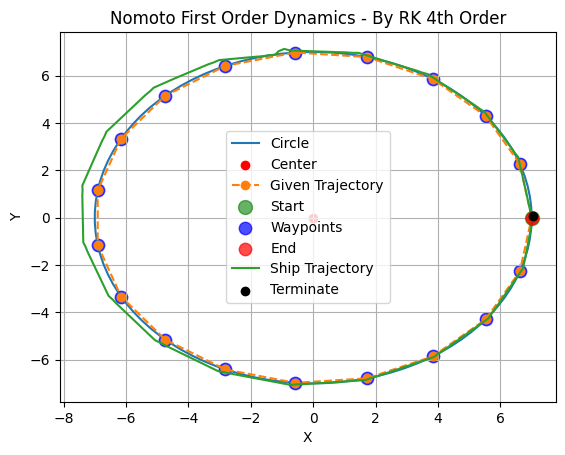

In [18]:
circle_center = (0, 0)
circle_radius = 7
num_waypoints = 20
draw_circle(circle_center, circle_radius)
x_waypoint, y_waypoint = divide_circle(circle_center, circle_radius, num_waypoints)

x_values = np.array([7])
y_values = np.array([0])
psi_values = np.array([1.5708])
r_values = np.array([0.0])
delta = 0.1
delta_t = 1

u=0.2
psi_d, los = LOS(x_values[-1],y_values[-1],x_waypoint,y_waypoint,6)

# Initialize PID controller with tuning parameters
Kp = 6.5
Ki = 0.1
Kd = 1

he = psi_d - psi_values[-1]

pid_controller = PIDController(Kp, Ki, Kd,he,he)

delta = float(pid_controller.update(he,1))

# x_waypoint = [0,8,15,30,50,90]
# y_waypoint = [0,10,18,25,35,10]

i=0

while i < (len(x_waypoint) - 1):

    xk = x_waypoint[i:i+2]
    yk = y_waypoint[i:i+2]
    print(f"xk={xk} and yk = {yk}")
    pathlen = dist(x_waypoint[i+1], y_waypoint[i+1], x_waypoint[i], y_waypoint[i])
    step = 0

    while True:
        step += 1
        x_values, y_values, psi_values, r_values = runge_kutta_nomoto(x_values, y_values, psi_values, r_values, delta, delta_t)

        psi_d, los = LOS(x_values[-1], y_values[-1], xk, yk, 6)

        he = psi_d - psi_values[-1]

        delta = float(pid_controller.update(he, 1))

        # Termination Conditions
        if dist(x_waypoint[i+1], y_waypoint[i+1], x_values[-1], y_values[-1]) <= 0.1:
            print(f'Termination_1 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

        if step * u >= 1.005 * pathlen:
            # print(f'X={x_values[-1]},Y={y_values[-1]}')
            print(f'Termination_2 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

    if i < (len(x_waypoint) - 1):
        i += 1
    else:
        print("No more waypoints to process")
        break

# Plot
plt.plot(x_waypoint, y_waypoint, linestyle='--', marker='o', label="Given Trajectory")
plt.scatter(x_waypoint[0], y_waypoint[0], color='green', label='Start', zorder=5, s=100, alpha=0.6)
plt.scatter(x_waypoint[1:-1], y_waypoint[1:-1], color='blue', label='Waypoints', marker='o', s=80, alpha=0.7)
plt.scatter(x_waypoint[-1], y_waypoint[-1], color='red', label='End', zorder=5, s=80, alpha=0.7)
plt.plot(x_values, y_values, label="Ship Trajectory")
plt.scatter(x_values[-1], y_values[-1], color='black', label='Terminate', zorder=5, marker='o')
plt.legend()
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nomoto First Order Dynamics - By RK 4th Order')
plt.show()


xk=[0, 8] and yk = [0, 10]
Termination_2 at steps =65 at waypoint 1
xk=[8, 15] and yk = [10, 18]
Termination_2 at steps =54 at waypoint 2
xk=[15, 30] and yk = [18, 25]
Termination_2 at steps =84 at waypoint 3
xk=[30, 50] and yk = [25, 35]
Termination_2 at steps =113 at waypoint 4
xk=[50, 90] and yk = [35, 10]
Termination_2 at steps =238 at waypoint 5


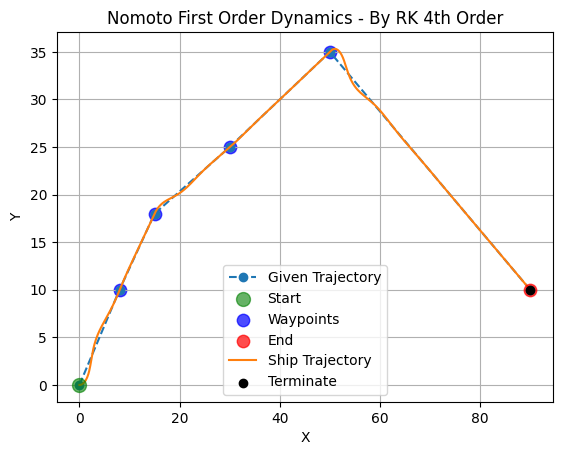

In [21]:
def generate_straight_line_path(start, end, num_points):

    x_values = np.linspace(start, end, num_points)
    y_values = np.zeros_like(x_values)
    return x_values, y_values

start_point = 0
end_point = 100
num_divisions = 6
# x_waypoint, y_waypoint = generate_straight_line_path(start_point, end_point, num_divisions)

x_values = np.array([0])
y_values = np.array([0])
psi_values = np.array([0])
r_values = np.array([0.0])
delta = 0.1
delta_t = 1

u=0.2
psi_d, los = LOS(x_values[-1],y_values[-1],xk,yk,6)

# Initialize PID controller with tuning parameters
Kp = 0.8
Ki = 0.1
Kd = 0.5

pid_controller = PIDController(Kp, Ki, Kd,he,he)

delta = float(pid_controller.update(he,1))

x_waypoint = [0,8,15,30,50,90]
y_waypoint = [0,10,18,25,35,10]

i=0

while i < (len(x_waypoint) - 1):

    xk = x_waypoint[i:i+2]
    yk = y_waypoint[i:i+2]
    print(f"xk={xk} and yk = {yk}")
    pathlen = dist(x_waypoint[i+1], y_waypoint[i+1], x_waypoint[i], y_waypoint[i])
    step = 0

    while True:
        step += 1
        x_values, y_values, psi_values, r_values = runge_kutta_nomoto(x_values, y_values, psi_values, r_values, delta, delta_t)

        psi_d, los = LOS(x_values[-1], y_values[-1], xk, yk, 6)

        he = psi_d - psi_values[-1]

        delta = float(pid_controller.update(he, 1))

        # Termination Conditions
        if dist(x_waypoint[i+1], y_waypoint[i+1], x_values[-1], y_values[-1]) <= 0.01:
            print(f'Termination_1 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

        if step * u >= 1.005 * pathlen:
            print(f'Termination_2 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

    if i < (len(x_waypoint) - 1):
        i += 1
    else:
        print("No more waypoints to process")
        break

# Plot
plt.plot(x_waypoint, y_waypoint, linestyle='--', marker='o', label="Given Trajectory")
plt.scatter(x_waypoint[0], y_waypoint[0], color='green', label='Start', zorder=5, s=100, alpha=0.6)
plt.scatter(x_waypoint[1:-1], y_waypoint[1:-1], color='blue', label='Waypoints', marker='o', s=80, alpha=0.7)
plt.scatter(x_waypoint[-1], y_waypoint[-1], color='red', label='End', zorder=5, s=80, alpha=0.7)
plt.plot(x_values, y_values, label="Ship Trajectory")
plt.scatter(x_values[-1], y_values[-1], color='black', label='Terminate', zorder=5, marker='o')
plt.legend()
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nomoto First Order Dynamics - By RK 4th Order')
plt.show()


xk=[4.         3.36501413] and yk = [4.         6.16256327]
Termination_2 at steps =12 at waypoint 1
xk=[3.36501413 1.66166005] and yk = [6.16256327 7.63852798]
Termination_2 at steps =12 at waypoint 2
xk=[ 1.66166005 -0.56925935] and yk = [7.63852798 7.95928577]
Termination_2 at steps =12 at waypoint 3
xk=[-0.56925935 -2.61944294] and yk = [7.95928577 7.0229983 ]
Termination_2 at steps =12 at waypoint 4
xk=[-2.61944294 -3.83797189] and yk = [7.0229983  5.12693023]
Termination_2 at steps =12 at waypoint 5
xk=[-3.83797189 -3.83797189] and yk = [5.12693023 2.87306977]
Termination_2 at steps =12 at waypoint 6
xk=[-3.83797189 -2.61944294] and yk = [2.87306977 0.9770017 ]
Termination_2 at steps =12 at waypoint 7
xk=[-2.61944294 -0.56925935] and yk = [0.9770017  0.04071423]
Termination_2 at steps =12 at waypoint 8
xk=[-0.56925935  1.66166005] and yk = [0.04071423 0.36147202]
Termination_2 at steps =12 at waypoint 9
xk=[1.66166005 3.36501413] and yk = [0.36147202 1.83743673]
Termination_2 at 

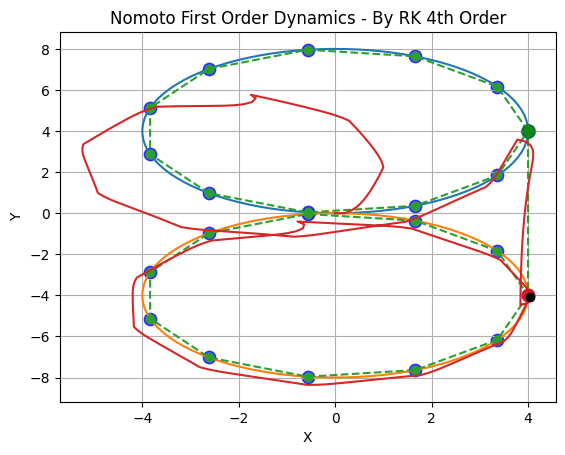

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_circle(center, radius, label):
    theta = np.linspace(0, 2*np.pi, 100)
    # print(f'theta={theta}')
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    plt.plot(x, y, label=label)

def divide_circle_symmetric(center, radius, num_points):
    theta = np.linspace(0, 2*np.pi, num_points,endpoint=True)
    x = center[0] + radius * np.cos(theta)
    y = center[1] + radius * np.sin(theta)
    return x, y

# Define circle parameters
radius = 4
center_top = (0, radius)
center_bottom = (0, -radius)

# Plot the circles
plot_circle(center_top, radius, 'Circle 1')
plot_circle(center_bottom, radius, 'Circle 2')

num_points = 12
x_waypoint_top, y_waypoint_top = divide_circle_symmetric(center_top, radius, num_points)
x_waypoint_bottom, y_waypoint_bottom = divide_circle_symmetric(center_bottom, radius, num_points)

# Concatenate the waypoints
x_waypoint = np.concatenate((x_waypoint_top, x_waypoint_bottom))
y_waypoint = np.concatenate((y_waypoint_top, y_waypoint_bottom))

x_values = np.array([0])
y_values = np.array([0])
psi_values = np.array([0])
r_values = np.array([0.0])
delta = 0.1
delta_t = 1

u=0.2
psi_d, los = LOS(x_values[-1],y_values[-1],xk,yk,6)

# Initialize PID controller with tuning parameters
Kp = 4
Ki = 0.1
Kd = 0.5


pid_controller = PIDController(Kp, Ki, Kd,he,he)

delta = float(pid_controller.update(he,1))

# x_waypoint = [0,8,15,30,50,90]
# y_waypoint = [0,10,18,25,35,10]

i=0

while i < (len(x_waypoint) - 1):

    xk = x_waypoint[i:i+2]
    yk = y_waypoint[i:i+2]
    print(f"xk={xk} and yk = {yk}")
    pathlen = dist(x_waypoint[i+1], y_waypoint[i+1], x_waypoint[i], y_waypoint[i])
    step = 0

    while True:
        step += 1
        x_values, y_values, psi_values, r_values = runge_kutta_nomoto(x_values, y_values, psi_values, r_values, delta, delta_t)

        psi_d, los = LOS(x_values[-1], y_values[-1], xk, yk, 6)

        he = psi_d - psi_values[-1]

        delta = float(pid_controller.update(he, 1))

        # Termination Conditions
        if dist(x_waypoint[i+1], y_waypoint[i+1], x_values[-1], y_values[-1]) <= 0.01:
            print(f'Termination_1 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

        if step * u >= 1.005 * pathlen:
            # print(f'X={x_values[-1]},Y={y_values[-1]}')
            print(f'Termination_2 at steps ={step} at waypoint {i+1}')
            # i += 1
            break

    # i += 1
    # print(f'i={i}')
    # print(len(xk))
    if i < (len(x_waypoint) - 1):
        i += 1
    else:
        print("No more waypoints to process")
        break

# Plot
plt.plot(x_waypoint, y_waypoint, linestyle='--', marker='o', label="Given Trajectory")
plt.scatter(x_waypoint[0], y_waypoint[0], color='green', label='Start', zorder=5, s=100, alpha=0.6)
plt.scatter(x_waypoint[1:-1], y_waypoint[1:-1], color='blue', label='Waypoints', marker='o', s=80, alpha=0.7)
plt.scatter(x_waypoint[-1], y_waypoint[-1], color='red', label='End', zorder=5, s=80, alpha=0.7)
plt.plot(x_values, y_values, label="Ship Trajectory")
plt.scatter(x_values[-1], y_values[-1], color='black', label='Terminate', zorder=5, marker='o')
# plt.legend()
plt.grid(True)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Nomoto First Order Dynamics - By RK 4th Order')
plt.show()

